In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle

from utils import *

# 10 seconds

In [6]:
#selected subset of dates. 
val_dates = ['171021','171023','180711','180714']
test_dates = ['171020','171022','180712','180713']
load_path = '/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/'
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
model_saving_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_yue/model_Goose_and_Jester'



train_files, val_files, test_files = create_files(load_path, val_dates, test_dates, bad_dates)
train_loader, val_loader, test_loader = create_dataloaders(train_files, val_files, test_files,load_path, batch_size=256)

In [7]:
print(len(train_loader), len(val_loader), len(test_loader))
for batch_idx, (data, label, date, rec, time) in enumerate(train_loader): # check shapes
    print(data.shape)
    print(label.shape)
    print(len(date))
    print(len(rec))
    print(len(time))
    break

251 24 25
torch.Size([256, 62, 100, 10])
torch.Size([256, 1])
256
256
256


#### LR with no reg

In [8]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'LR'
loss_type = 'bce'
reg_type = 'none'
time_window = 10
CH = 'all'


model = GLM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [9]:
model_LR = os.listdir(model_saving_path)
results = []
alphas = [0]
for alpha in alphas:
    best_result = 0
    reg_alpha = 'REG'+reg_type+str(alpha)+'_'
    tw = 'TW'+str(time_window)
    for i, s in enumerate(model_LR):
        if 'LR_CHall_' in s and reg_alpha in s and tw in s:
            model_name = model_LR[i].split('_')
            epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
            res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
            if len(res) > 1:
                epoch_result = res[0]*10+res[1]
            else:
                epoch_result = res[0]
            if epoch_result>best_result and epoch_result != 50:
                best_result = epoch_result

    results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
0          3


/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_yue/model_Goose_and_Jester/LR_CHall_LOSSbce_REGnone0_TW10_EPOCH3.pt


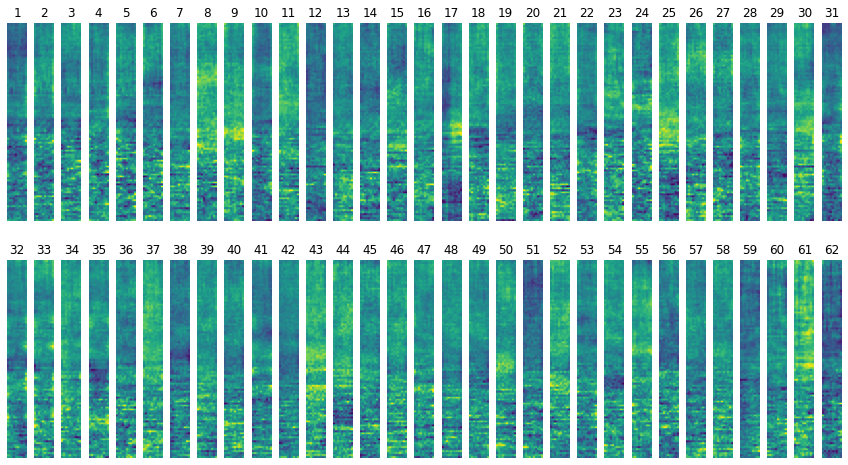

validation loss:1.3475474119186401 accuracy:0.6676849966055669
0.8616769
test loss:1.1566816568374634 accuracy:0.7087685976574866
0.82114595


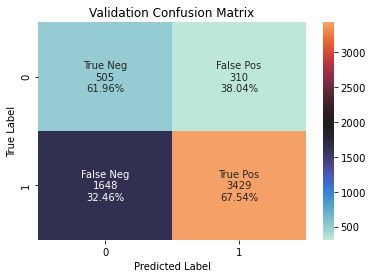

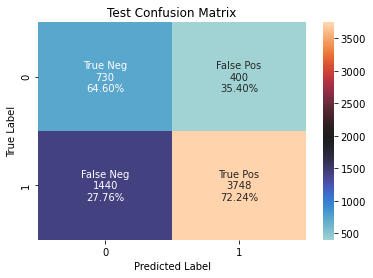

In [10]:
for i,(index,row) in enumerate(best_results.iterrows()):
    
    save_path = model_saving_path
    best_epoch = int(row)
    alpha = index
    # load best model
    model = GLM(62*100*time_window).to(device)
    path = model_saving_path
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch)))


    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch))

    ## Show features
    weights = model.linear.weight.view(62, 100, time_window)
    plt.figure(figsize=(15,8))
    for i in range(62):
        weights_sub = weights[i].detach().cpu()
        plt.subplot(2,31,i+1)
        plt.axis('off')
        plt.imshow(weights_sub)
        plt.title(str(i+1))
        # plt.clim(-0.03, 0.03)
    plt.show()

    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_preds_probs, val_labels,_,_,_, cases_wrong_1 = evaluate(model, optimizer, val_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    print(np.mean(np.concatenate(val_labels)))

    ## Calculate test accuracy and test loss
    test_loss, test_acc, test_preds, test_preds_probs, test_labels,_,_,_, cases_wrong_2 = evaluate(model, optimizer, test_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
    print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
    print(np.mean(np.concatenate(test_labels)))

    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)

    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

    ## Confusion matrix-test
    predictions_test = np.concatenate(test_preds)
    labels_test = np.concatenate(test_labels)

    df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

    cm_test = confusion_matrix(labels_test, predictions_test)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_test.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
    ax.set_title('Test Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

    # ## Wrong Classifications
    # path_wrong = '/mnt/pesaranlab/People/Capstone_students/Yue/wrong_pred'
    # pickle.dump(cases_wrong_1, open('{}/{}_CH{}_LOSS{}_REG{}{}.pt'.format(path_wrong, model_type, CH, loss_type, reg_type, alpha), 'wb'))
    # idx = 0
    # print('date:{}, rec:{}, time:{}, label:{}'.format(cases_wrong_1[0][0], cases_wrong_1[0][1], cases_wrong_1[0][2], cases_wrong_1[0][3]))
    # print('Original data 62 CH')
    # weights_sub = cases_wrong_1[0][-1][0]
    # plt.axis('off')
    # plt.imshow(weights_sub)
    # # plt.clim(-0.03, 0.03)
    # plt.show()

#### LR with L2 Regulation

In [11]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'LR'
loss_type = 'bce'
reg_type = 'l2'
time_window = 10
CH = 'all'


model = GLM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [12]:
model_LR = os.listdir(model_saving_path)
results = []
alphas = [1,50,100]
for alpha in alphas:
    best_result = 0
    reg_alpha = 'REG'+reg_type+str(alpha)+'_'
    tw = 'TW'+str(time_window)
    for i, s in enumerate(model_LR):
        if 'LR_CHall_' in s and reg_alpha in s and tw in s:
            model_name = model_LR[i].split('_')
            epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
            res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
            if len(res) > 1:
                epoch_result = res[0]*10+res[1]
            else:
                epoch_result = res[0]
            if epoch_result>best_result and epoch_result != 50:
                best_result = epoch_result

    results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
1          2
50        15
100       41


/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_yue/model_Goose_and_Jester/LR_CHall_LOSSbce_REGl21_TW10_EPOCH2.pt


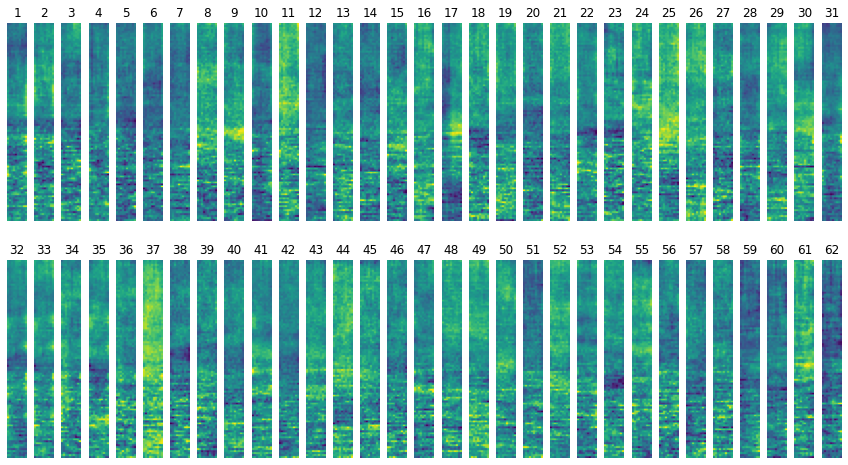

validation loss:1.2364462614059448 accuracy:0.6965376782077393
0.8616769
test loss:1.1252460479736328 accuracy:0.7241215574548908
0.82114595


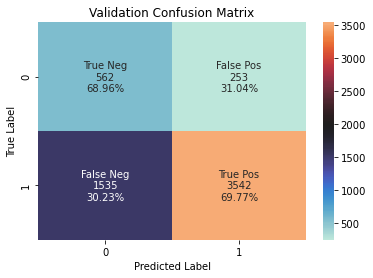

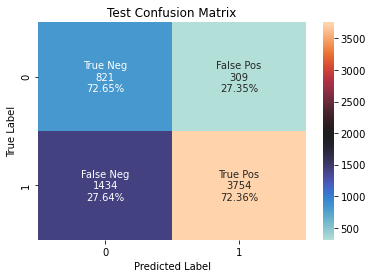

/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_yue/model_Goose_and_Jester/LR_CHall_LOSSbce_REGl250_TW10_EPOCH15.pt


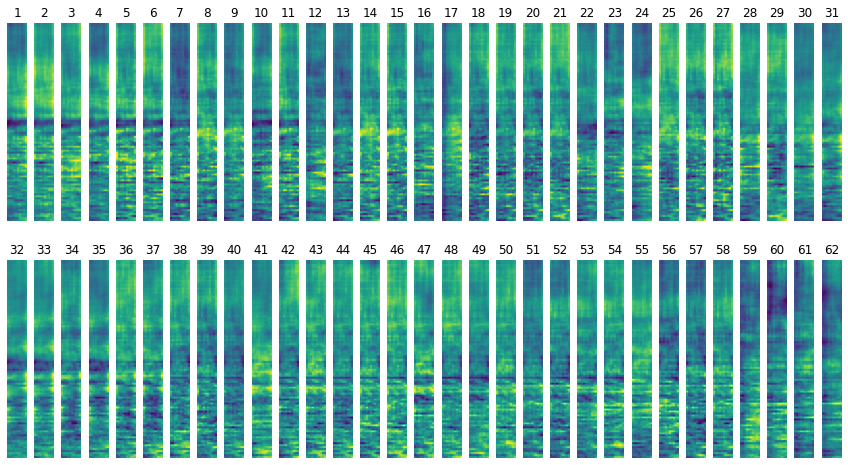

validation loss:0.5159952044487 accuracy:0.8167006109979633
0.8616769
test loss:0.5350103974342346 accuracy:0.8200379867046533
0.82114595


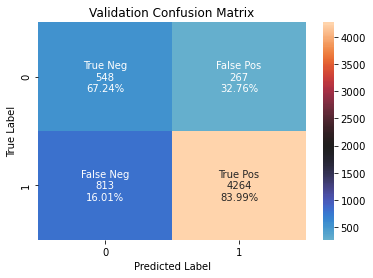

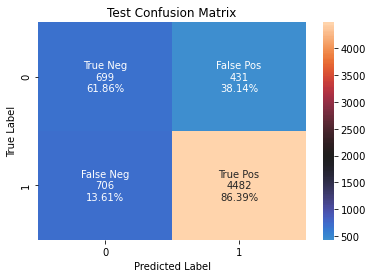

/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_yue/model_Goose_and_Jester/LR_CHall_LOSSbce_REGl2100_TW10_EPOCH41.pt


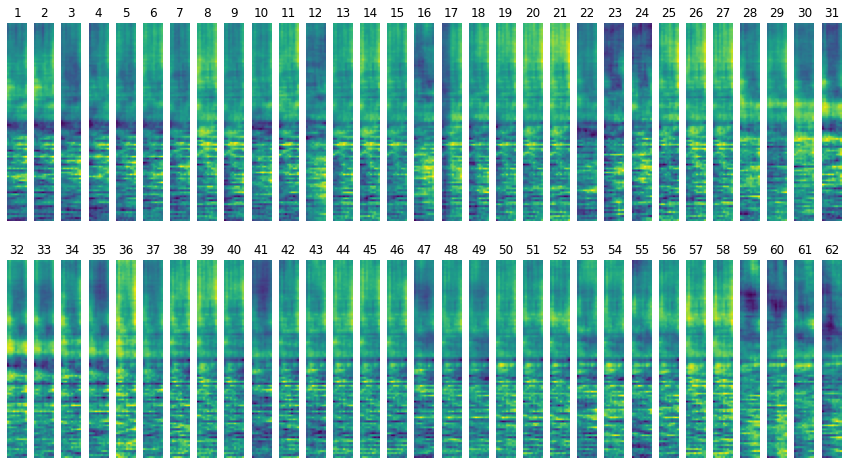

validation loss:0.4740077555179596 accuracy:0.8379158180583842
0.8616769
test loss:0.4851610064506531 accuracy:0.8331750553972777
0.82114595


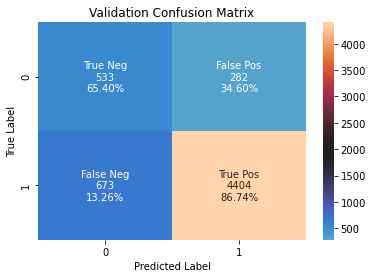

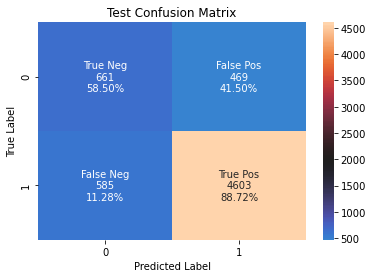

In [13]:
for i,(index,row) in enumerate(best_results.iterrows()):
    
    save_path = model_saving_path
    best_epoch = int(row)
    alpha = index
    # load best model
    model = GLM().to(device)
    path = model_saving_path
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch)))


    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch))

    ## Show features
    weights = model.linear.weight.view(62, 100, 10)
    plt.figure(figsize=(15,8))
    for i in range(62):
        weights_sub = weights[i].detach().cpu()
        plt.subplot(2,31,i+1)
        plt.axis('off')
        plt.imshow(weights_sub)
        plt.title(str(i+1))
        # plt.clim(-0.03, 0.03)
    plt.show()

    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_preds_probs, val_labels,_,_,_, cases_wrong_1 = evaluate(model, optimizer, val_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    print(np.mean(np.concatenate(val_labels)))

    ## Calculate test accuracy and test loss
    test_loss, test_acc, test_preds, test_preds_probs, test_labels,_,_,_, cases_wrong_2 = evaluate(model, optimizer, test_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
    print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
    print(np.mean(np.concatenate(test_labels)))

    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)

    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

    ## Confusion matrix-test
    predictions_test = np.concatenate(test_preds)
    labels_test = np.concatenate(test_labels)

    df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

    cm_test = confusion_matrix(labels_test, predictions_test)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_test.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
    ax.set_title('Test Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

    # ## Wrong Classifications
    # path_wrong = '/mnt/pesaranlab/People/Capstone_students/Yue/wrong_pred'
    # pickle.dump(cases_wrong_1, open('{}/{}_CH{}_LOSS{}_REG{}{}.pt'.format(path_wrong, model_type, CH, loss_type, reg_type, alpha), 'wb'))
    # idx = 0
    # print('date:{}, rec:{}, time:{}, label:{}'.format(cases_wrong_1[0][0], cases_wrong_1[0][1], cases_wrong_1[0][2], cases_wrong_1[0][3]))
    # print('Original data 62 CH')
    # weights_sub = cases_wrong_1[0][-1][0]
    # plt.axis('off')
    # plt.imshow(weights_sub)
    # # plt.clim(-0.03, 0.03)
    # plt.show()

#### LR with finite difference Regulation

In [14]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'LR'
loss_type = 'bce'
reg_type = 'finite_diff'
time_window = 10
CH = 'all'


model = GLM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [15]:
model_LR = os.listdir(model_saving_path)
results = []
alphas = [1,50,100]
for alpha in alphas:
    best_result = 0
    reg_alpha = 'REG'+reg_type+str(alpha)+'_'
    tw = 'TW'+str(time_window)
    for i, s in enumerate(model_LR):
        if 'LR_CHall_' in s and reg_alpha in s and tw in s:
            model_name = model_LR[i].split('_')
            epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
            res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
            if len(res) > 1:
                epoch_result = res[0]*10+res[1]
            else:
                epoch_result = res[0]
            if epoch_result>best_result and epoch_result != 50:
                best_result = epoch_result

    results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
1          0
50         0
100       42


/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_yue/model_Goose_and_Jester/LR_CHall_LOSSbce_REGfinite_diff1_TW10_EPOCH0.pt


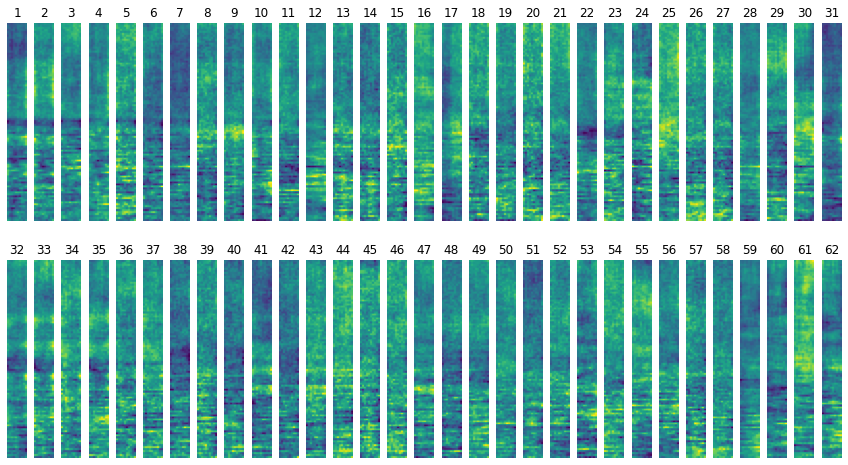

validation loss:1.1788346767425537 accuracy:0.6043788187372708
0.8616769
test loss:1.1286360025405884 accuracy:0.6540044317822096
0.82114595


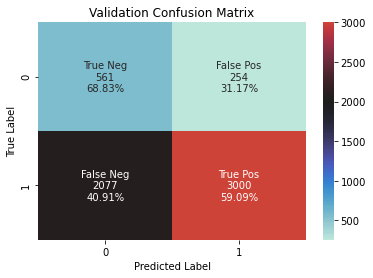

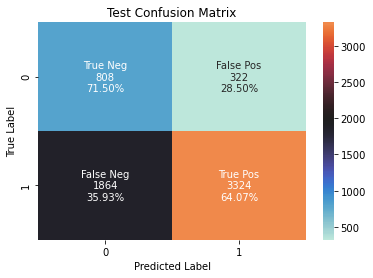

/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_yue/model_Goose_and_Jester/LR_CHall_LOSSbce_REGfinite_diff50_TW10_EPOCH0.pt


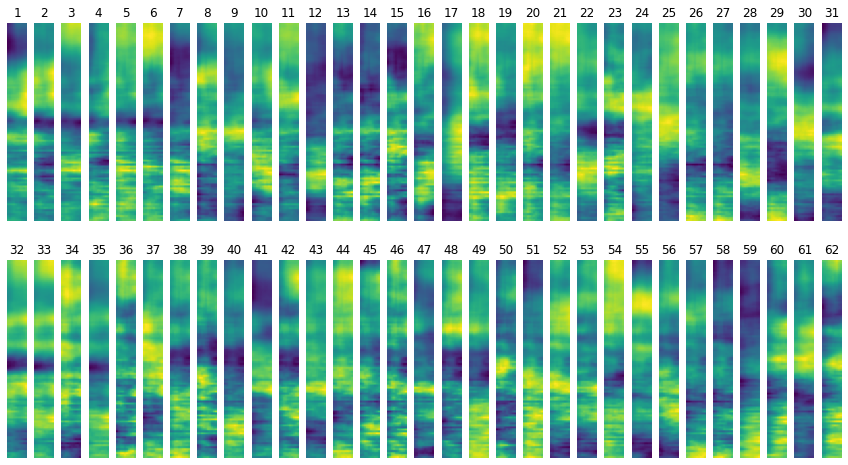

validation loss:1.0115259885787964 accuracy:0.6347589952477937
0.8616769
test loss:0.9507242441177368 accuracy:0.6872427983539094
0.82114595


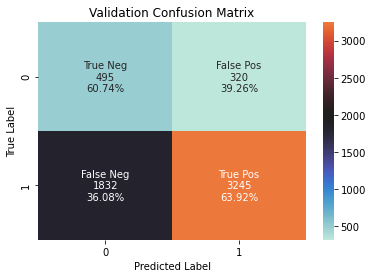

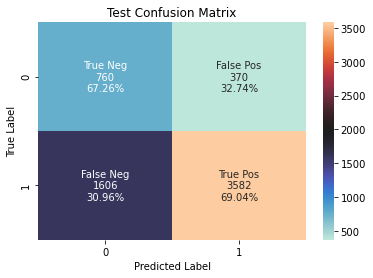

/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_yue/model_Goose_and_Jester/LR_CHall_LOSSbce_REGfinite_diff100_TW10_EPOCH42.pt


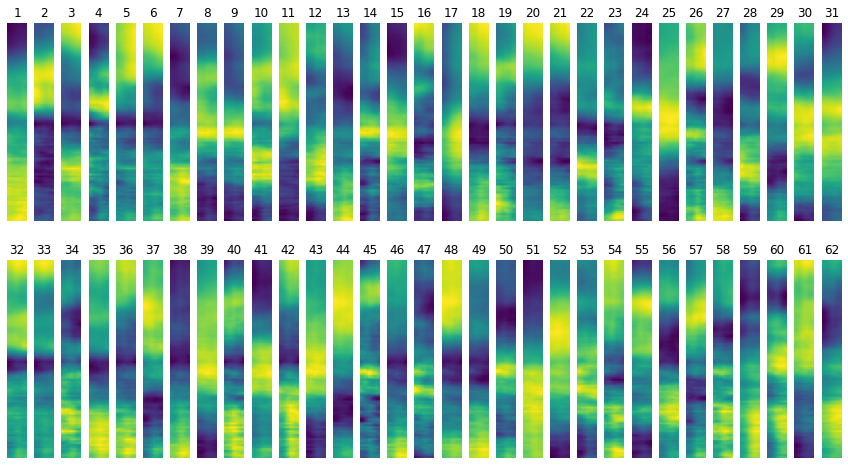

validation loss:0.8526471853256226 accuracy:0.7306517311608961
0.8616769
test loss:0.7785876393318176 accuracy:0.7660652105096549
0.82114595


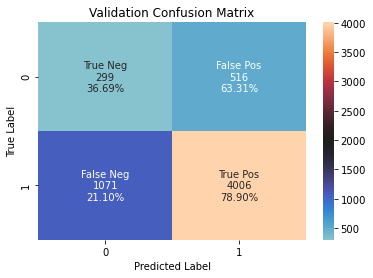

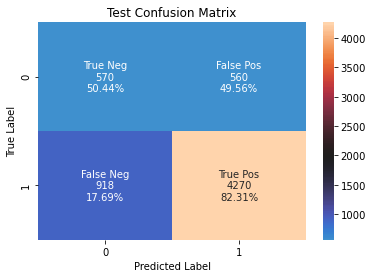

In [16]:
for i,(index,row) in enumerate(best_results.iterrows()):
    
    save_path = model_saving_path
    best_epoch = int(row)
    alpha = index
    # load best model
    model = GLM().to(device)
    path = model_saving_path
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch)))


    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch))

    ## Show features
    weights = model.linear.weight.view(62, 100, 10)
    plt.figure(figsize=(15,8))
    for i in range(62):
        weights_sub = weights[i].detach().cpu()
        plt.subplot(2,31,i+1)
        plt.axis('off')
        plt.imshow(weights_sub)
        plt.title(str(i+1))
        # plt.clim(-0.03, 0.03)
    plt.show()

    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_preds_probs, val_labels,_,_,_, cases_wrong_1 = evaluate(model, optimizer, val_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    print(np.mean(np.concatenate(val_labels)))

    ## Calculate test accuracy and test loss
    test_loss, test_acc, test_preds, test_preds_probs, test_labels,_,_,_, cases_wrong_2 = evaluate(model, optimizer, test_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
    print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
    print(np.mean(np.concatenate(test_labels)))

    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)

    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

    ## Confusion matrix-test
    predictions_test = np.concatenate(test_preds)
    labels_test = np.concatenate(test_labels)

    df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

    cm_test = confusion_matrix(labels_test, predictions_test)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_test.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
    ax.set_title('Test Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

    # ## Wrong Classifications
    # path_wrong = '/mnt/pesaranlab/People/Capstone_students/Yue/wrong_pred'
    # pickle.dump(cases_wrong_1, open('{}/{}_CH{}_LOSS{}_REG{}{}.pt'.format(path_wrong, model_type, CH, loss_type, reg_type, alpha), 'wb'))
    # idx = 0
    # print('date:{}, rec:{}, time:{}, label:{}'.format(cases_wrong_1[0][0], cases_wrong_1[0][1], cases_wrong_1[0][2], cases_wrong_1[0][3]))
    # print('Original data 62 CH')
    # weights_sub = cases_wrong_1[0][-1][0]
    # plt.axis('off')
    # plt.imshow(weights_sub)
    # # plt.clim(-0.03, 0.03)
    # plt.show()